In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

In [2]:
np.random.seed(42)

In [3]:
dados = pd.read_csv("../src/dados_completos.csv")

Inicialmente eu vou pegar os dados e fazer a média de cada mês por cidade, então teremos os dados na seguinte disposição:

\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Cidade} & 01 & 02 & 03 & \cdots & 12 \\
\hline
\text{Abreu e Lima} & 7.61 & 10.58 & 9.12 & \cdots & 8.95 \\
\text{Afogados...} & 5.23 & 6.89 & 7.45 & \cdots & 4.12 \\
\hline
\end{array}

In [4]:
monthly_avg = dados.groupby(['Cidade', dados['Data'].str.split('-').str[1]])['Precipitacao_mm_mes'].mean().unstack()
monthly_avg.columns = [f'Precip_Media_Mes_{i+1:02d}' for i in range(12)]

Abaixo eu vou pegar as informações de Latitude, Logitude e Mesorregião de cada cidade e em seguinte vou agrupar, 
então os dados vão ficar com a seguinte diposição:
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
\text{Cidade} & \text{01} & \text{02} & \text{03} & \cdots & \text{12} & \text{Latitude} & \text{Longitude} & \text{Mesorregião} \\
\hline
\text{Abreu e Lima} & 7.61 & 10.58 & 9.12 & \cdots & 8.95 & -7.9116 & 34.90 & \text{Metropolitana do Recife} \\
\hline
\text{Afogados...} & 5.23 & 6.89 & 7.45 & \cdots & 4.12 & -7.75 & 37.64 & \text{Sertão Pernambucano} \\
\hline
\end{array}

In [5]:
# Adicionar informações geográficas
cidades_info = dados.groupby('Cidade')[['Latitude', 'Longitude', 'Mesorregião']].first()
dados_agregados = monthly_avg.merge(cidades_info, left_index=True, right_index=True)

Eu pego as colunas de precipitação e coloco elas em uma lista e determino que essa lista vai ser nossa feature

In [6]:
# Preparar os dados para clustering (usando apenas as features de precipitação)
features = [f'Precip_Media_Mes_{i+1:02d}' for i in range(12)]
X = dados_agregados[features]

Normalizo os dados

In [7]:
# Normalizar os dados (importante para K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

WCSS mede quão "compactos" são os clusters. É a soma das distâncias quadradas de cada ponto até o centroide do seu cluster.
Fórmula: WCSS = Σ (distância de cada ponto ao centroide do seu cluster)²
O que acontece na prática:

Com 1 cluster:

* Todas as cidades em um grupo só
* WCSS alto (pontos muito espalhados)

Com 2 clusters:

* Divisão básica (ex: litoral vs interior)
* WCSS diminui significativamente

Com 3 clusters:

* Divisão mais refinada (ex: litoral, agreste, sertão)
* WCSS diminui mais 

.
.
.

Com 10 clusters:
* Grupos muito específicos
* WCSS muito baixo (cada cluster tem poucas cidades muito similares)

In [8]:
# Determinar o número ideal de clusters usando o método do cotovelo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly d

Visualização:

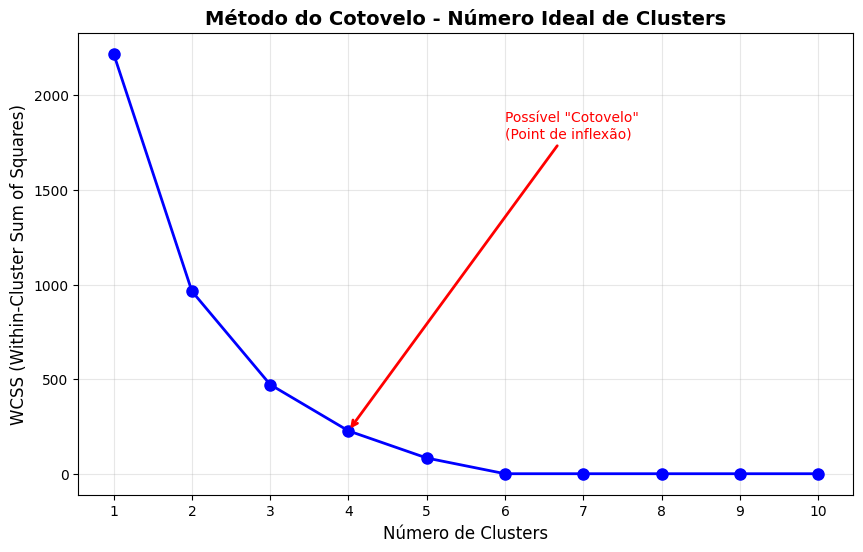

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, 'bo-', linewidth=2, markersize=8)
plt.title('Método do Cotovelo - Número Ideal de Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 11))

plt.annotate('Possível "Cotovelo"\n(Point de inflexão)', 
             xy=(4, wcss[3]),
             xytext=(6, wcss[0]*0.8),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=10, color='red')

plt.show()

K-menans em si

De acordo com o gráfico vemos que a quantidade ideal é 4
* 4 clusters é o ponto ideal
* Menos que 4 seria muito genérico
* Mais que 4 seria muito específico (overfitting)

Depois criamos o modelo do k-means com o número de clusteres igual ao ideal apresentado no gráfico, com o random state de 42 para haver reprodubilidade e o número de unidade que é quantas vezes o algoritmo vai rodar até achar o ideal

Em seguidas os clusteres são criados e é mostrado ao final quantas cidades fica em cada cluster

In [10]:
k_ideal = 4

# Aplicar K-Means
kmeans = KMeans(n_clusters=k_ideal, random_state=42, n_init=32)
clusters = kmeans.fit_predict(X_scaled)

# Adicionar os clusters ao dataframe
dados_agregados['Cluster'] = clusters

print("\nDistribuição dos clusters:")
print(dados_agregados['Cluster'].value_counts().sort_index())


Distribuição dos clusters:
Cluster
0     10
1    121
2     39
3     15
Name: count, dtype: int64


* O primeiro gráfico mostra o padrão de precipição de cada cluster ao longos dos meses
* O Segundo gráfico mostra geográficamente os clusteres. Ele pega a latitude e a longitude de cada cidade e mostra a que cluster aquela cidade pertence
* O Terceiro gráfico mostra quantas cidades de cada mesorregião pertece a determinado cluster

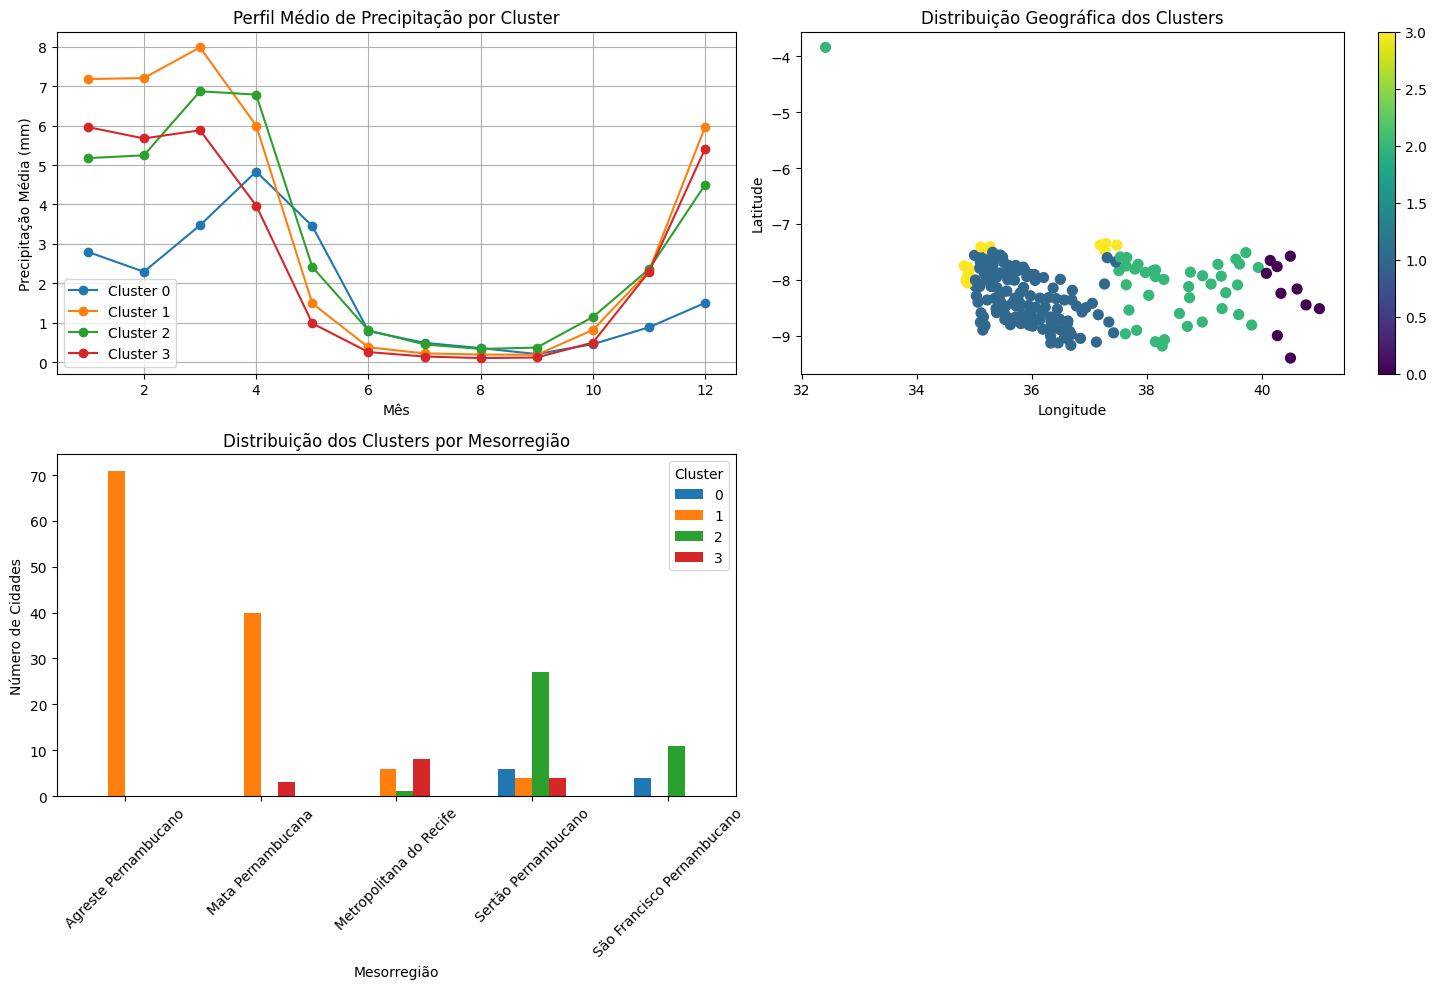

In [11]:
# Analisar os perfis de precipitação de cada cluster
cluster_profiles = dados_agregados.groupby('Cluster')[features].mean()

plt.figure(figsize=(15, 10))

# Plot 1: Perfis de precipitação por cluster
plt.subplot(2, 2, 1)
for cluster in range(k_ideal):
    plt.plot(range(1, 13), cluster_profiles.loc[cluster], marker='o', label=f'Cluster {cluster}')
plt.title('Perfil Médio de Precipitação por Cluster')
plt.xlabel('Mês')
plt.ylabel('Precipitação Média (mm)')
plt.legend()
plt.grid(True)

# Plot 2: Distribuição geográfica
plt.subplot(2, 2, 2)
scatter = plt.scatter(dados_agregados['Longitude'], dados_agregados['Latitude'], 
                     c=dados_agregados['Cluster'], cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title('Distribuição Geográfica dos Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot 3: Distribuição por mesorregião
plt.subplot(2, 2, 3)
cross_tab = pd.crosstab(dados_agregados['Mesorregião'], dados_agregados['Cluster'])
cross_tab.plot(kind='bar', ax=plt.gca())
plt.title('Distribuição dos Clusters por Mesorregião')
plt.xlabel('Mesorregião')
plt.ylabel('Número de Cidades')
plt.xticks(rotation=45)
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

Vizualicação de cada cidade que pertece a cada cluster

In [12]:
print("\n=== CIDADES POR CLUSTER ===")
for cluster in range(k_ideal):
    cidades_cluster = dados_agregados[dados_agregados['Cluster'] == cluster].index.tolist()
    print(f"\nCluster {cluster} ({len(cidades_cluster)} cidades):")
    print(", ".join(cidades_cluster))


=== CIDADES POR CLUSTER ===

Cluster 0 (10 cidades):
Afrânio, Araripina, Dormentes, Ipubi, Lagoa Grande, Ouricuri, Petrolina, Santa Cruz, Santa Filomena, Trindade

Cluster 1 (121 cidades):
Agrestina, Alagoinha, Aliança, Altinho, Amaraji, Angelim, Araçoiaba, Arcoverde, Barra de Guabiraba, Barreiros, Belo Jardim, Belém de Maria, Bezerros, Bom Conselho, Bom Jardim, Bonito, Brejo da Madre de Deus, Brejão, Buenos Aires, Buíque, Cabo de Santo Agostinho, Cachoeirinha, Caetés, Calçado, Camocim de São Félix, Canhotinho, Capoeiras, Carpina, Caruaru, Casinhas, Catende, Chã Grande, Chã de Alegria, Condado, Correntes, Cortês, Cumaru, Cupira, Escada, Feira Nova, Frei Miguelinho, Gameleira, Garanhuns, Glória do Goitá, Goiana, Gravatá, Iati, Ibirajuba, Ingazeira, Ipojuca, Itaquitinga, Itaíba, Jaboatão dos Guararapes, Jaqueira, Jataúba, Joaquim Nabuco, João Alfredo, Jucati, Jupi, Jurema, Lagoa de Itaenga, Lagoa do Carro, Lagoa do Ouro, Lagoa dos Gatos, Lajedo, Limoeiro, Macaparana, Machados, Maraial, 

O gráfico mostra (ainda não consegui entender o gráfico)

Depois agente compara várias metricas para varios valores de K. Com o objtivo múltiplas métricas para encontrar o K ideal de forma objetiva.

* Silhouette Score: Quão bem cada ponto se encaixa no seu cluster vs nos outros clusters
* Calinski-Harabasz Index: Razão entre a dispersão ENTRE clusters vs DENTRO dos clusters
* Davies-Bouldin Index: Similaridade média entre cada cluster e seu cluster mais similar
* WCSS (Within-Cluster Sum of Squares): Compactidade total dos clusters - soma das distâncias ao quadrado de cada ponto até seu centroide

c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


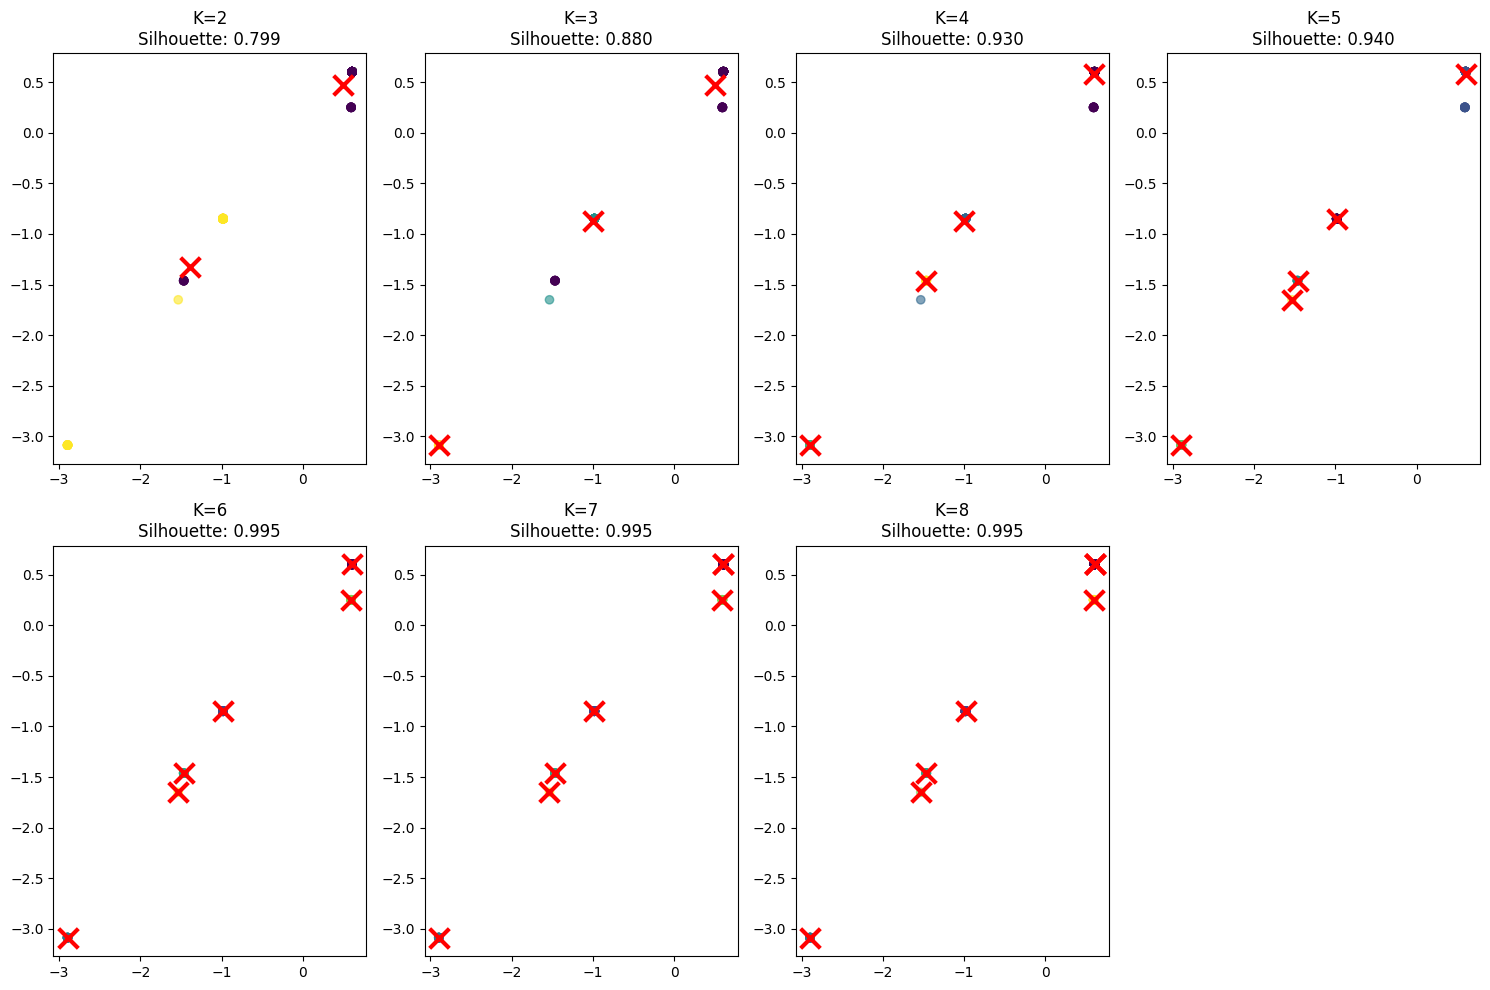

=== ANÁLISE COMPARATIVA ===
   k  silhouette      calinski  davies     wcss
0  2       0.799  2.382570e+02   0.608  964.398
1  3       0.880  3.377830e+02   0.208  471.147
2  4       0.930  5.309940e+02   0.126  226.507
3  5       0.940  1.158479e+03   0.054   83.009
4  6       0.995  5.240100e+31   0.000    0.000
5  7       0.995  5.240100e+31   0.000    0.000
6  8       0.995  5.240100e+31   0.000    0.000

MELHORES K:
   Por Silhouette: K=6.0 (score: 0.995)
   Por Calinski: K=8.0 (score: 52401003457978232275863492100096.00)
   Por Davies: K=6.0 (score: 0.000)


In [13]:
def encontrar_melhor_k(X, k_max=10):
    """Encontra o melhor K usando múltiplas métricas"""
    
    k_range = range(2, k_max + 1)
    resultados = []
    
    plt.figure(figsize=(15, 10))
    
    for i, k in enumerate(k_range, 1):
        # Executar K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X)
        
        # Calcular métricas
        silhouette = silhouette_score(X, clusters)
        calinski = calinski_harabasz_score(X, clusters)
        davies = davies_bouldin_score(X, clusters)
        wcss = kmeans.inertia_
        
        resultados.append({
            'k': k, 'silhouette': silhouette, 'calinski': calinski,
            'davies': davies, 'wcss': wcss
        })
        
        # Plot dos clusters (primeiros 2 componentes)
        plt.subplot(2, 4, i)
        plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', alpha=0.6)
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                   marker='x', s=200, linewidths=3, color='red')
        plt.title(f'K={k}\nSilhouette: {silhouette:.3f}')
    
    plt.tight_layout()
    plt.show()
    
    # Análise das métricas
    df_resultados = pd.DataFrame(resultados)
    
    print("=== ANÁLISE COMPARATIVA ===")
    print(df_resultados.round(3))
    
    # Encontrar melhores K por cada métrica
    best_silhouette = df_resultados.loc[df_resultados['silhouette'].idxmax()]
    best_calinski = df_resultados.loc[df_resultados['calinski'].idxmax()]
    best_davies = df_resultados.loc[df_resultados['davies'].idxmin()]
    
    print(f"\nMELHORES K:")
    print(f"   Por Silhouette: K={best_silhouette['k']} (score: {best_silhouette['silhouette']:.3f})")
    print(f"   Por Calinski: K={best_calinski['k']} (score: {best_calinski['calinski']:.2f})")
    print(f"   Por Davies: K={best_davies['k']} (score: {best_davies['davies']:.3f})")
    
    return df_resultados

# Executar análise
df_k_analysis = encontrar_melhor_k(X_scaled, k_max=8)